In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/TCC LOCAL/projeto/datasets/fer.zip' >> /dev/null

In [2]:
!mkdir outputs_treinamento

In [4]:
import os
from os.path import join as join_path
import cv2
import json
import tensorflow as tf
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

SEED = 42

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

BASE_PATH = join_path('/content', 'fer')
BASE_CSV_PATH = '/content/drive/MyDrive/TCC LOCAL/projeto/outputs_treinamento/fer_extraction'
# BASE_CSV_PATH = join_path('/content', 'outputs_treinamento')
BATCH_SIZE = 32
LE_PATH = BASE_CSV_PATH + '/le.csv'
MODEL_PATH = '/content/drive/MyDrive/TCC LOCAL/projeto/outputs_treinamento/vgg16_svm/model_svm.sav'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGES_FOLDER = BASE_PATH
IMG_SIZE = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  IMAGES_FOLDER + '/train',
  image_size=(IMG_SIZE, IMG_SIZE),
  seed=SEED,
  batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  IMAGES_FOLDER + '/test',
  image_size=(IMG_SIZE, IMG_SIZE),
  seed=SEED,
  batch_size=BATCH_SIZE,
)

datagen = ImageDataGenerator(
  rotation_range=0.2,
  shear_range=0.15, 
  rescale=1./255,
)

train_gen = datagen.flow_from_directory(
  IMAGES_FOLDER + '/train',
  target_size=(IMG_SIZE, IMG_SIZE),
  seed=SEED,
  batch_size=BATCH_SIZE,
)

validation_gen = datagen.flow_from_directory(
  IMAGES_FOLDER + '/test',
  target_size=(IMG_SIZE, IMG_SIZE),
  seed=SEED,
  batch_size=BATCH_SIZE,
)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False)
base_model.trainable = False 

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import ELU, ReLU
from keras.layers.core import Activation, Flatten

def build_advanced_net(model_weights=None, image_size: int = 224, classes: int = 7) -> Sequential:
  conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3)
  )

  print(conv_base.layers)

  for layer in conv_base.layers:
    layer.trainable = False
    
  for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

  """
  model = Sequential()
  model.add(conv_base)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(classes, activation='softmax'))
  """

  model = Sequential()
  model.add(conv_base)
  # Block #4: first set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(64, kernel_initializer="he_normal"))
  model.add(ReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Block #6: second set of FC => RELU layers
  model.add(Dense(64, kernel_initializer="he_normal"))
  model.add(ReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Block #7: softmax classifier
  model.add(Dense(classes, kernel_initializer="he_normal"))
  model.add(Activation("softmax"))

  if model_weights is not None:
    model.load_weights(model_weights)
    1
  model.layers[0].trainable = False

  for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable  )

  return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

NUM_EPOCHS = 100
BATCH_SIZE = 128
LEARN_RATE = 0.001
TEST_RATIO = 0.2
NUM_CLASSES = 7

MODEL_DIR = '/content/MODEL'

# create and compile model
print('[INFO] creating model...')
model = build_advanced_net()
model.summary()
optimizer = Adam(learning_rate=LEARN_RATE)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print('[INFO] model compiled.')

# train model
ES = EarlyStopping(monitor='val_loss', patience=10)
# Alterei para ver se muda o desempenho (originalmente está em callbacks)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

MC = ModelCheckpoint(MODEL_DIR + '/model_e_{epoch:02d}.hdf5',
                      save_best_only=True,
                      save_weights_only=True)
print('[INFO] starting training...')
H = model.fit(train_gen,
              epochs=NUM_EPOCHS,
              validation_data=validation_gen,
              callbacks=[lr_reduce, MC],
              verbose=1)
print('[INFO] model trained.')

[INFO] creating model...
[<keras.engine.input_layer.InputLayer object at 0x7f69ab2d1d90>, <keras.layers.convolutional.Conv2D object at 0x7f69ab291590>, <keras.layers.convolutional.Conv2D object at 0x7f69ab73f390>, <keras.layers.pooling.MaxPooling2D object at 0x7f69ab303490>, <keras.layers.convolutional.Conv2D object at 0x7f69ab28e790>, <keras.layers.convolutional.Conv2D object at 0x7f69ab32b650>, <keras.layers.pooling.MaxPooling2D object at 0x7f69aa249d90>, <keras.layers.convolutional.Conv2D object at 0x7f69aa23bd90>, <keras.layers.convolutional.Conv2D object at 0x7f69adc1ae10>, <keras.layers.convolutional.Conv2D object at 0x7f69aa23eb90>, <keras.layers.pooling.MaxPooling2D object at 0x7f69adc1ef90>, <keras.layers.convolutional.Conv2D object at 0x7f69aa24a250>, <keras.layers.convolutional.Conv2D object at 0x7f69ab2d1590>, <keras.layers.convolutional.Conv2D object at 0x7f69adc26b90>, <keras.layers.pooling.MaxPooling2D object at 0x7f69adc2d6d0>, <keras.layers.convolutional.Conv2D object 

OSError: ignored

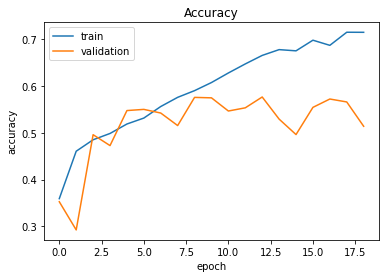

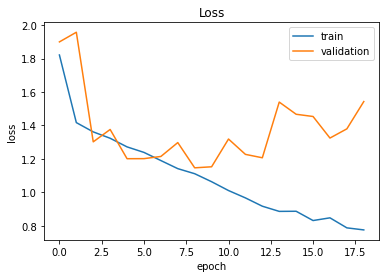

In [ ]:
# plot loss and accuracy history
plt.figure()
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig(MODEL_DIR + '/model_accuracy.png')
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig(MODEL_DIR + '/model_loss.png')

In [ ]:
model.save(MODEL_DIR + '/model_freezing_10es.hdf5')

Usei 600 epochs baseado no trabalho de mendonça